# Lab 6 - Convolutional Neural Networks
by Rebecca Kuhlman, Sam Yao, and Michael Amberg



Business Understanding
Identifying the type of brain tumor a patient has is an important step in figuring out the treatment plan of a patient. They can be diagnosed via MRI imaging, leading to interest in using machine learning to diagnose the patient. Having a second opinion on brain tumor diagnoses would help improve patient care and outcomes, and lessen stress on doctors. A machine learning model could also speed up analysis time and pick out which patients are in need of urgent treatment.
In this dataset, there is glioma, meningioma, and pituitary tumors, as well as MRI images with no tumors. Glioma tumors are usually malignant, while meningioma and pituitary tumors are usually benign. Different types of tumors are made of different types of cells and have a location where they are most likely to be located. More information can be found at: https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084
There are many other types of tumors that future algorithms will be need to address. The majority of other types of tumors are more common in children, while the set we are dealing with are all adult brain images.
Because the model deals with health conditions that have extreme affects on the patient, model accuracy is extremely important. Furthermore, accuracy must fine-tuned to avoid fatal misdiagnosis. While incorrectly marking a patient with a benign tumor as malignant is wasteful, the adverse affects are minimal. Inversely, misdiagnosing a malignant tumor as benign may have fatal effects for the patient. Therefore, the designed model must minimize the rate of false negatives with accuracy of 95% or more.
It should be noted that the majority of misdiagnose of brain tumors happen before a brain scan or related test is ordered. https://paulandperkins.com/brain-tumors/

## Preparation

[1.5 points] 
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

Because we will be dealing with identifying brain tumors, we want to use Recall. The equation for Recall takes into account False Negatives, which would be very bad if you falsely cleared someone of brain tumors, but they did in fact have a tumor. This will be a high stakes identification, so at the very least our recall score should be 85% accuarate to be deployed.

[1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

We could try Stratified 10 k-fold validation, because it seemed to be effective from the results we had in the last lab. I have no idea if this would extend to image data, but we could give it a try.
Stratified 10 k-fold validation is most effective with small amounts of imbalanced data. We have to think about balance a lot in our data as our tumor categories will have differing likelihoods, and we have a lot of different types of MRI photos.
In a deployment setting, different tumors (or when we are actually getting a tumor) will come up at different rates. There are many types of tumors with different subcategories, we will only be training our program for 3 types of brain tumors. Our program must be robust under these uneven circumstances. Stratified 10 k-fold validation would be one way to address this.

https://www.analyseup.com/python-machine-learning/stratified-kfold.html
https://www.aans.org/en/Patients/Neurosurgical-Conditions-and-Treatments/Brain-Tumors

## Modeling

[1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/ Links to an external site.)

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import struct

# This method creates the data, whether training or testing, in the form we desire
# Reused code from Lab 2
def create_dataset(img_folder):
    # Read through all files in "img_folder"
    img_data_array = []
    class_name = []
    
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            img = cv2.imread(os.path.join(img_folder,dir1,file))
            img = cv2.resize(img,(256, 256)) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)         #Images are in grayscale anyway, may as well make it official
            img_normalized = cv2.normalize(img,None,0,1.0,
                                           cv2.NORM_MINMAX, 
                                           dtype=cv2.CV_32F)
            img_data_array.append([img_normalized])             #Image bracketed to ensure that each image shows one channel
            class_name.append(dir1)
    
    # return array with training data.
    img_data_array = np.array(img_data_array)
    class_name = np.array(class_name)
    return img_data_array, class_name

In [2]:
#Load the training and testing datasets
df_training, training_classes = create_dataset("./Training")
df_testing, testing_classes = create_dataset("./Testing")

#Reshape the training and testing datasets
df_training = df_training.reshape((df_training.shape[0], 256, 256, 1))
df_testing = df_testing.reshape((df_testing.shape[0], 256, 256, 1))

In [3]:
np.unique(training_classes)

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

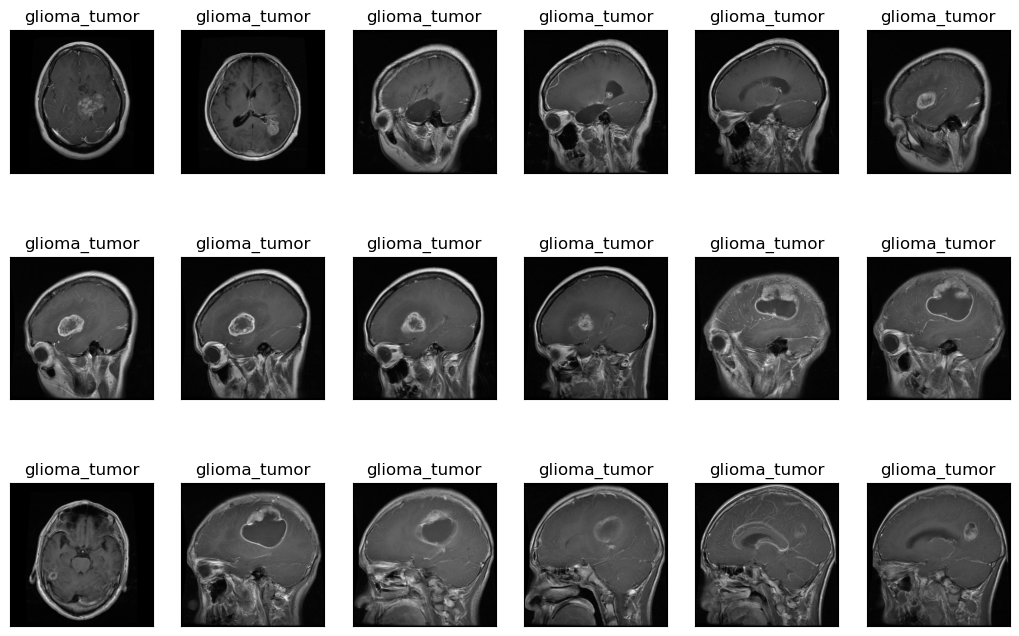

In [4]:
import random

# Helper Function to plot pictures
# Taken from Dr. Larson's Notebook
# Modified to show random images of tumors and their categories
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    
    #r = random.randint(0,(2870 - (n_row * n_col))) #This part was added to randomly show tumor pics
    
    
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+ 1)
        
        # Random dist. added here
        plt.imshow(images[i].reshape((h, w)).astype('float'), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        
        plt.xticks(())
        plt.yticks(())
plot_gallery(df_training, training_classes, 256, 256, 3, 6) # defaults to showing a 3 by 6 subset of the faces

In [ ]:
# Cell to categorize the training/testing classes for fitting the MLP

for i in range(len(training_classes)):
    if training_classes[i] == ('glioma_tumor'):
        training_classes[i] = 1
    elif training_classes[i] == ('meningioma_tumor'):
        training_classes[i] = 2
    elif training_classes[i] == ('no_tumor'):
        training_classes[i] = 0   
    elif training_classes[i] == ('pituitary_tumor'):
        training_classes[i] = 3
        
for i in range(len(testing_classes)):
    if testing_classes[i] == ('glioma_tumor'):
        testing_classes[i] = 1
    elif testing_classes[i] == ('meningioma_tumor'):
        testing_classes[i] = 2
    elif testing_classes[i] == ('no_tumor'):
        testing_classes[i] = 0   
    elif testing_classes[i] == ('pituitary_tumor'):
        testing_classes[i] = 3

training_classes = training_classes.astype(int)
testing_classes = testing_classes.astype(int)

### Data Augmentation

[1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10, # used, Int. Degree range for random rotations.
    width_shift_range=0.15, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.15, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0.05, # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.1, # Float. Zoom intensity could be 
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(df_training)

Above are the settings for Data Augmentation. To list them out nicely:
- Rotation Range: 10 degrees
- Width/Height Shift Range: 15% 
- Shear: 5%
- Zoom: 10%
- Horizontal Flip: No
- Vertical Flip: No

Rotation Range and Width/Height Shift Range: We chose 10 degrees and 25% respectively because not all heads and brains are shaped the same, so it's possible that there could be some slight variation in this area. Thus it is best to take this into account.

Shear: Again, this is done for good measure (at only 5%) to account for variation in brain and head shapes and sizes.

Zoom: Set at 10% to account for variation in brain and head shapes/sizes.

Horizontal/Vertical Flip:In most of the training data and in various brain scans found online, the MRI is taken on the left side of the person's head, so we assume that MRI's are typically taken this way. Of course, this could be a faulty assumption, as none of us have extensive experience or domain knowledge with brain scans. 


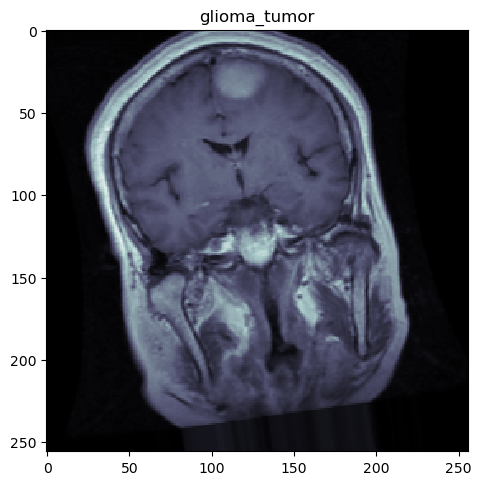

In [9]:
import matplotlib.pyplot as plt
from skimage.io import imshow
tmps = datagen.flow(df_training, training_classes, batch_size=1)
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for tmp in tmps:
     imshow(tmp[0].squeeze(),cmap='bone')
     plt.title(labels[np.argmax(tmp[1])])
     break

In [35]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
NUM_CLASSES = 4

#One Hot Encode the target variables
y_train_ohe = keras.utils.to_categorical(training_classes, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(testing_classes, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30,
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mse',
              optimizer='rmsprop',
              metrics=[tf.keras.metrics.Recall()])

%time mlp.fit(df_training, y_train_ohe, batch_size=32, epochs=150, shuffle=True, verbose=0)
'''mlp.fit(datagen.flow(df_training, training_classes, batch_size=32),
        steps_per_epoch=int(len(df_training)/32),
        validation_data=datagen.flow(df_training,training_classes),
        epochs=150, shuffle=True, verbose= 0)'''

CPU times: user 1min 55s, sys: 51.6 s, total: 2min 47s
Wall time: 34.9 s


'mlp.fit(datagen.flow(df_training, training_classes, batch_size=32),\n        steps_per_epoch=int(len(df_training)/32),\n        validation_data=datagen.flow(df_training,training_classes),\n        epochs=150, shuffle=True, verbose= 0)'

### The following code is to save and load models efficiently
<hr>
<hr>
<hr>

In [48]:
mlp.save('my_little_perceptron.keras',overwrite=True,save_format="keras")

In [49]:
model = keras.models.load_model("my_little_perceptron.keras")

<hr>
<hr>
<hr>

In [9]:
# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same',
                input_shape=(8,8,1),
               ) )

cnn.add( MaxPooling2D(pool_size=(2, 2)) )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 16)          80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 16)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 1,108
Trainable params: 1,108
Non-trainable params: 0
____________________________________________________

    Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge.
    [1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models.
    [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.



In [10]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))

    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))

compare_mlp_cnn(cnn,mlp,df_testing,testing_classes)


ValueError: in user code:

    /users/samyao/.conda/envs/ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /users/samyao/.conda/envs/ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /users/samyao/.conda/envs/ML/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /users/samyao/.conda/envs/ML/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /users/samyao/.conda/envs/ML/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /users/samyao/.conda/envs/ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /users/samyao/.conda/envs/ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /users/samyao/.conda/envs/ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /users/samyao/.conda/envs/ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (None, 256, 256, 3)


<Figure size 1500x500 with 0 Axes>

Exceptional Work (1 points total)
Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance.

In [11]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# manipulated from Keras Documentation
#  https://keras.io/applications/
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')
res_model.summary()



102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [ ]:
import cv2
import numpy as np
import time
import itertools
%matplotlib inline

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

if 'res_model' not in locals():
    res_model = ResNet50(weights='imagenet')

ESC_KEY = 27

# setup some windows for viewing
cv2.namedWindow("demowin1")
cv2.startWindowThread()

# open the video card for capture
vc = cv2.VideoCapture(0)

if vc.isOpened():  # try to get the first frame
    print ("vc opened, getting first frame")
    rval, frame = vc.read()
    # this will likely fail the first time
    # the webcam often needs some time to open fully
    key = 0
else:
    print ("vc not open, exiting")
    key = ESC_KEY

while key != ESC_KEY and vc.isOpened():  # the escape key and the capture device is open
    rval, frame = vc.read()
    key = cv2.waitKey(10)

    if rval and frame is not None:

        frame_to_show = cv2.pyrDown(frame)  # make smaller immediately
        # grab the ROI in top left (will show later on)
        frame_down = frame_to_show[0:224,0:224]

        # increase contrast
        img_yuv = cv2.cvtColor(frame_down, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])# equalize the histogram of the Y channel
        frame_down = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)# convert the YUV image back to RGB format

        # and then remove noise
        frame_down = cv2.fastNlMeansDenoisingColored(frame_down,None,7,10,7,21)
# h (Optional): filter strength (luminance). Larger h value removes noise but alsoß image details
# hColor (Optional):  The same as h but for color components.
#    For most images value equals 10 will be enough to remove noise and not distort colors
# templateWindowSize (Optional): Size in pixels of the template patch that is used to compute weights. Should be odd.
#    Recommended value 7 pixels
# searchWindowSize (Optional): Size in pixels of the window that is used to compute weighted average for given pixel. Should be odd. Affect performance linearly: greater searchWindowsSize - greater denoising time.
#    Recommended value 21 pixels

        img = frame_down.copy() # make a copy for numpy

        x = image.img_to_array(img[:,:,::-1]) # convert to numpy
        x = np.expand_dims(x, axis=0) # add batch dimension
        x = preprocess_input(x) # apply resnet presets

        preds = res_model.predict(x) # get the predictions

        # decode the results into a list of tuples (class, description, probability)
        txt = str(decode_predictions(preds, top=3)[0])

        cv2.putText(frame_to_show, txt, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, [255, 255, 255])
        cv2.rectangle(frame_to_show, (0,0), (224,224), (255,255,255), 1)
        cv2.imshow("demowin1", frame_to_show)

print('releasing...')
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
print('Done')